<a href="https://colab.research.google.com/github/qorganbek/ComputerVision-Spring-2024/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
#task to retrain the model with and save the results for 40 epochs, to save the ootput images on every 10 epochs (10,20,30,40)
#bonus task (2 points) to change the model of generator to make the quality of generated images higher with the same number of epochs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = '/content/drive/MyDrive/cats/'
#https://drive.google.com/drive/folders/1elzimVxSfa6KY7BvOhbA_fZBmO2qH3TV?usp=share_link

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
import os
from PIL import Image
from torchvision.transforms import ToTensor

class CatImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_paths = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define your transformations
transform = tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

# Create the dataset
train_ds = CatImageDataset(DATA_DIR, transform=transform)



In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

FileNotFoundError: Couldn't find any class folder in /content/drive/MyDrive/cats/.

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

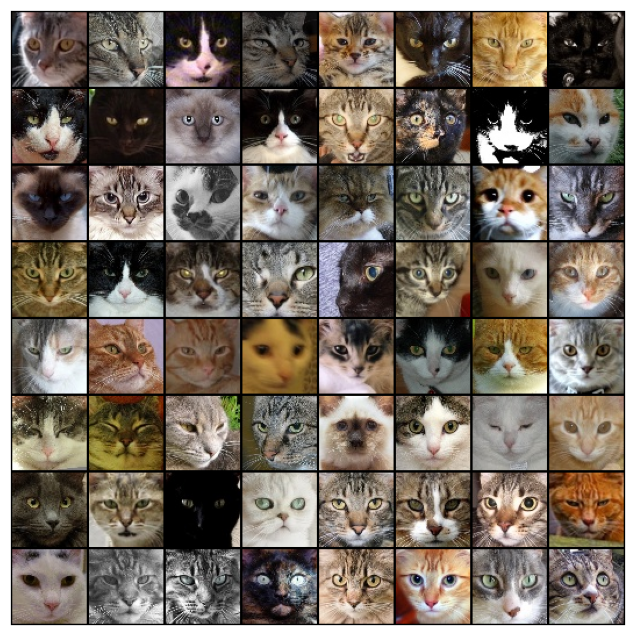

In [ ]:
show_batch(train_dl)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


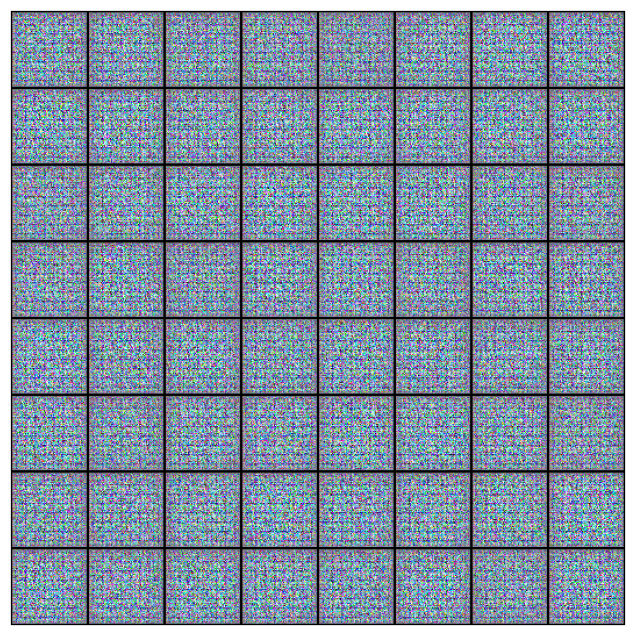

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Save generated images
        # if epoch == epochs - 1:
        #   save_samples(epoch+start_idx, fixed_latent, show=False)

        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 40

In [ ]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 9.1828, loss_d: 0.4494, real_score: 0.8696, fake_score: 0.1455


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 3.4583, loss_d: 0.7029, real_score: 0.7591, fake_score: 0.2368


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 3.3821, loss_d: 0.7226, real_score: 0.7470, fake_score: 0.2507


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 3.6428, loss_d: 0.7980, real_score: 0.7317, fake_score: 0.2613


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 3.8223, loss_d: 0.8489, real_score: 0.7250, fake_score: 0.2751


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 4.2385, loss_d: 0.7213, real_score: 0.7629, fake_score: 0.2376


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 4.1709, loss_d: 0.7993, real_score: 0.7482, fake_score: 0.2470


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 4.3410, loss_d: 0.7096, real_score: 0.7713, fake_score: 0.2299


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 4.1153, loss_d: 0.7260, real_score: 0.7656, fake_score: 0.2341


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 3.9743, loss_d: 0.7712, real_score: 0.7502, fake_score: 0.2499
Saving generated-images-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 4.2027, loss_d: 0.7100, real_score: 0.7771, fake_score: 0.2227


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 4.2880, loss_d: 0.6624, real_score: 0.7844, fake_score: 0.2062


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 4.0963, loss_d: 0.6937, real_score: 0.7878, fake_score: 0.2237


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 4.2458, loss_d: 0.6530, real_score: 0.7915, fake_score: 0.1999


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 4.2711, loss_d: 0.6330, real_score: 0.7987, fake_score: 0.2006


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 4.2055, loss_d: 0.5817, real_score: 0.8113, fake_score: 0.1885


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 4.2242, loss_d: 0.5547, real_score: 0.8232, fake_score: 0.1747


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 4.8413, loss_d: 0.5407, real_score: 0.8348, fake_score: 0.1629


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 4.6862, loss_d: 0.4783, real_score: 0.8558, fake_score: 0.1477


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 5.0405, loss_d: 0.5115, real_score: 0.8563, fake_score: 0.1372
Saving generated-images-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 5.0504, loss_d: 0.4734, real_score: 0.8592, fake_score: 0.1442


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 5.1711, loss_d: 0.4359, real_score: 0.8737, fake_score: 0.1260


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 5.1005, loss_d: 0.4149, real_score: 0.8820, fake_score: 0.1155


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 6.1503, loss_d: 0.2787, real_score: 0.9167, fake_score: 0.0906


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 5.9360, loss_d: 0.3055, real_score: 0.9000, fake_score: 0.0960


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 5.4895, loss_d: 0.4415, real_score: 0.8868, fake_score: 0.1126


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 5.2227, loss_d: 0.3776, real_score: 0.8790, fake_score: 0.1174


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 6.2681, loss_d: 0.1426, real_score: 0.9478, fake_score: 0.0578


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 8.7002, loss_d: 0.2001, real_score: 0.9531, fake_score: 0.0528


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 6.2694, loss_d: 0.3539, real_score: 0.8931, fake_score: 0.1049
Saving generated-images-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 6.0891, loss_d: 0.2858, real_score: 0.9038, fake_score: 0.0909


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 5.8395, loss_d: 0.4975, real_score: 0.8776, fake_score: 0.1237


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 5.4755, loss_d: 0.3419, real_score: 0.8916, fake_score: 0.1035


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 5.5441, loss_d: 0.4071, real_score: 0.8839, fake_score: 0.1150


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 5.8960, loss_d: 0.2623, real_score: 0.9211, fake_score: 0.0802


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 6.1562, loss_d: 0.2880, real_score: 0.9133, fake_score: 0.0872


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 5.9644, loss_d: 0.2872, real_score: 0.9137, fake_score: 0.0869


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 6.1740, loss_d: 0.2882, real_score: 0.9157, fake_score: 0.0868


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 5.9461, loss_d: 0.2116, real_score: 0.9262, fake_score: 0.0719


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 6.4904, loss_d: 0.2328, real_score: 0.9301, fake_score: 0.0717
Saving generated-images-0040.png


Saving generated-images-0040.png


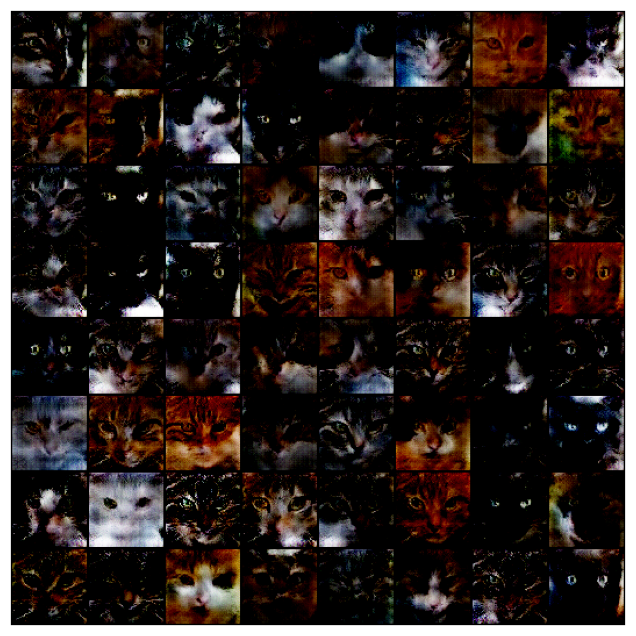

In [ ]:
save_samples(epochs, fixed_latent, show=True)

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
import os

sample_dir = os.getcwd()  # This will get the current working directory
print("Current working directory:", sample_dir)
!ls
%cd generated

Current working directory: /content/generated
generated-images-0000.png  generated-images-0020.png  generated-images-0030.png
generated-images-0010.png  generated-images-0025.png  generated-images-0040.png
[Errno 2] No such file or directory: 'generated'
/content/generated


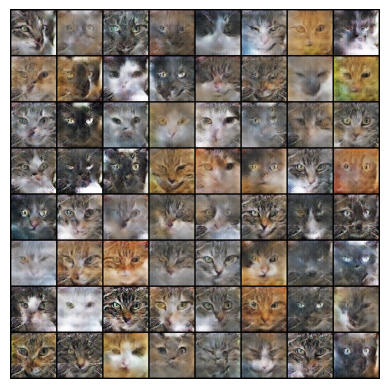

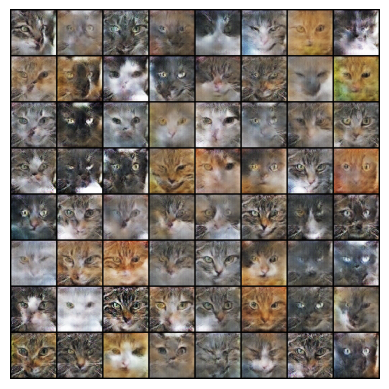

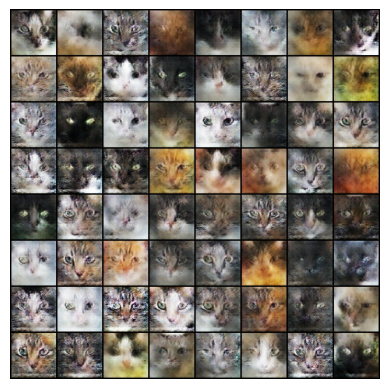

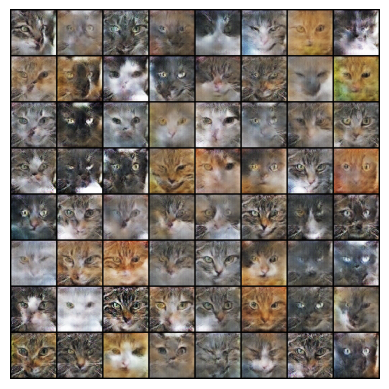

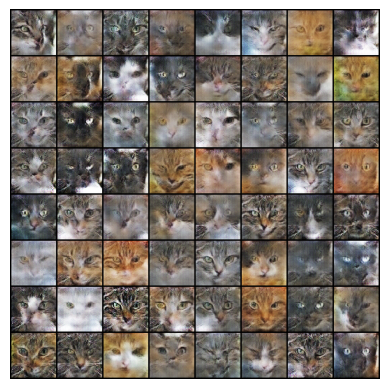

In [ ]:
import matplotlib.image as mpimg

def show_saved_samples(sample_dir):
    for i in range(0, 41, 10):
        fake_fname = 'generated-images-{0:04d}.png'.format(i)
        file_path = os.path.join(sample_dir, fake_fname)
        img = mpimg.imread(file_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

show_saved_samples('/content/generated/')


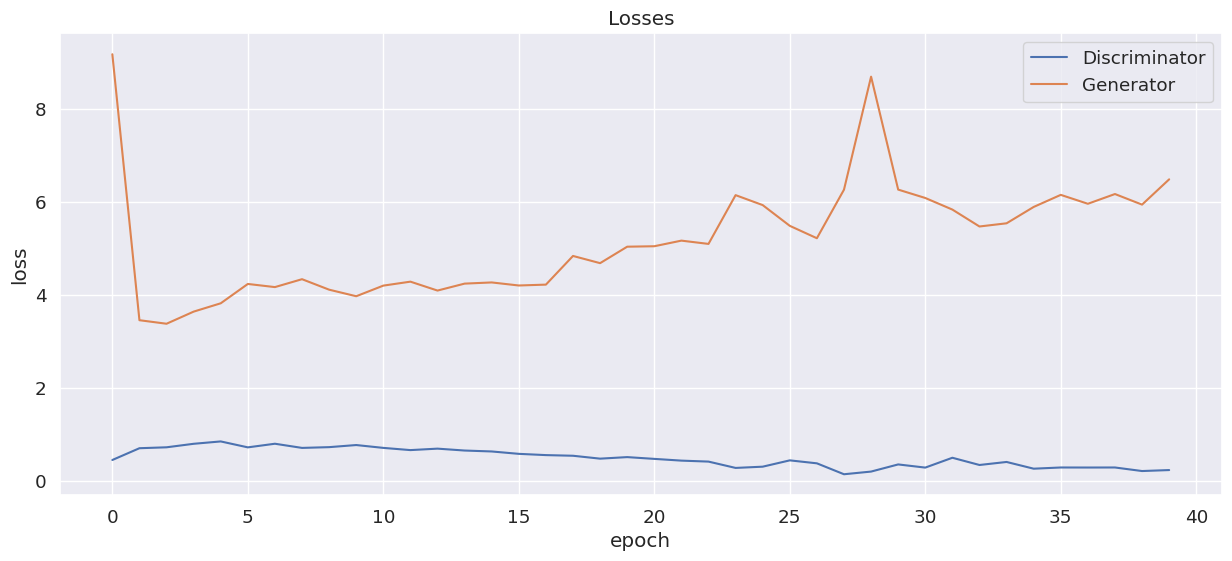

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

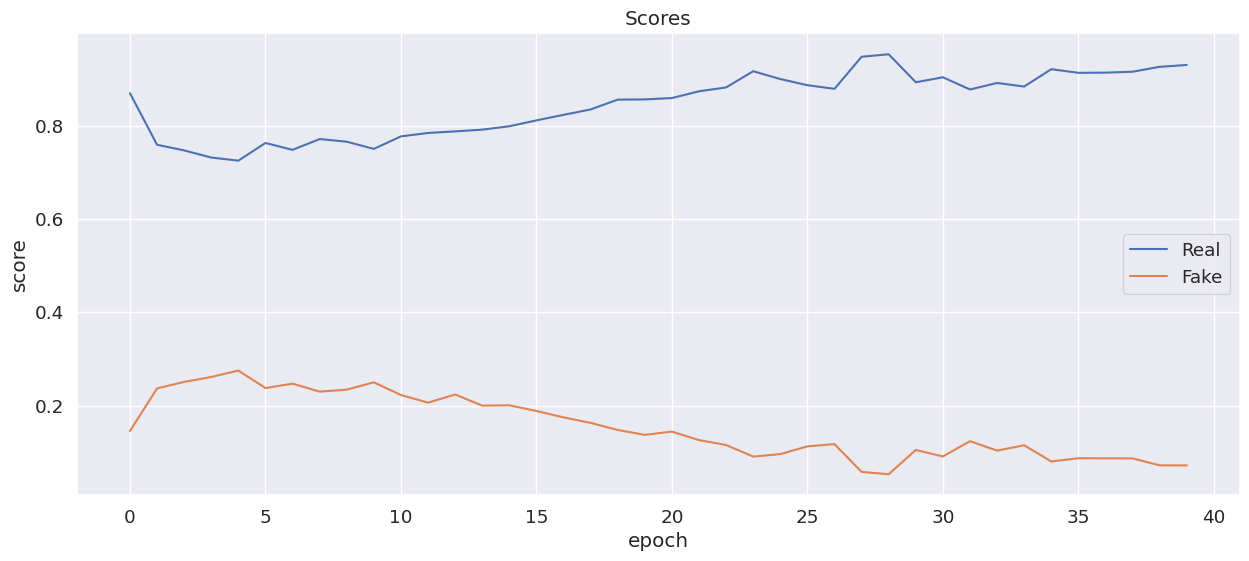

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');